In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

## Prepare Data 


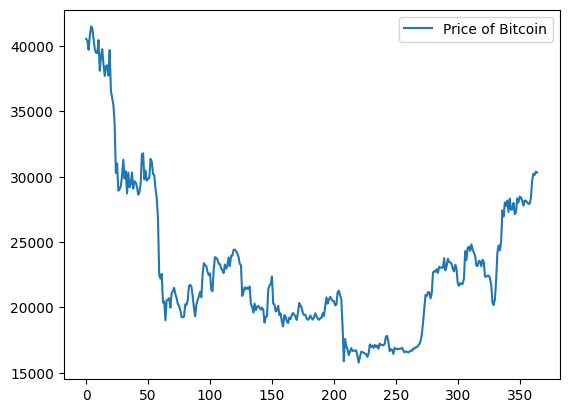

In [4]:
#Load in data
df = pd.read_csv(r"C:\Users\Owner\Documents\Predicting Crypto Prices via Senitment Analysis\BTC-USD.csv", parse_dates=['Date'])

prices = df['Close'].values
plt.plot(prices)
plt.legend(["Price of Bitcoin"])
plt.show()

### Plot ACF 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(prices)
plt.show()

### Create log returns of bitcoin price

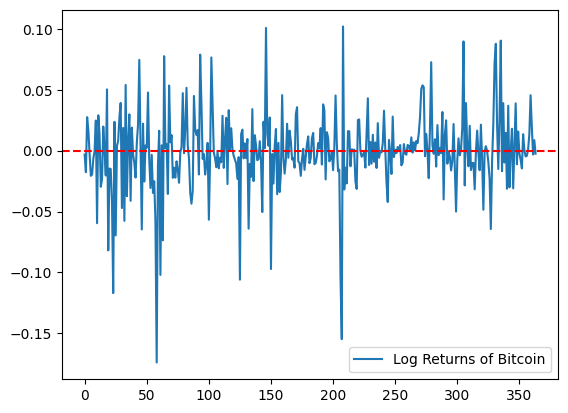

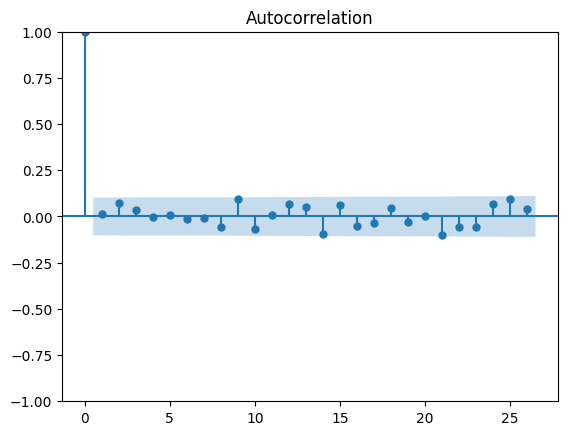

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


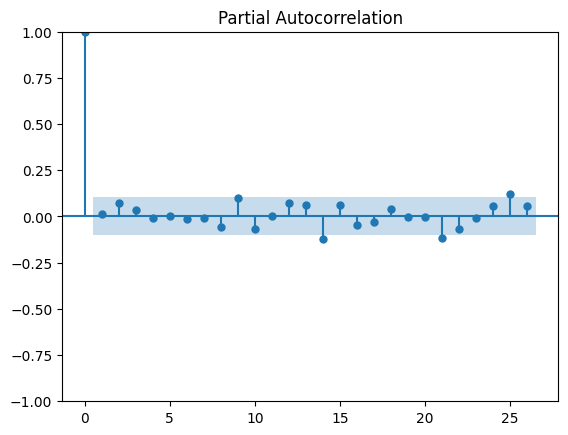

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

#Log the data to create log returns
timeseries = np.log(prices)

#1st difference of ts to remove trend and seasonality
diff = []
for i in range(1, len(timeseries)):
 value = timeseries[i] - timeseries[i - 1]
 diff.append(value)

diff = np.array(diff)
diff.resize((364,1))

diff = diff.astype('float32')

plt.plot(diff)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(["Log Returns of Bitcoin"])
plt.show()

plot_acf(diff)
plt.show()

plot_pacf(diff)
plt.show()




### Train-Test Split

In [15]:
# train-test split for time series
train_size = int(len(diff) * 0.67)
test_size = len(diff) - train_size
train, test = diff[:train_size], diff[train_size:]

print(len(train))
print(len(test))

243
121


### Create tensor dataset

In [16]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        inputs = dataset[i:i+lookback]
        labels = dataset[i+lookback:i+lookback+1]
        X.append(inputs)
        y.append(labels)
    return torch.tensor(X), torch.tensor(y)

lookback = 10
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

## LSTM Class


In [17]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=40, num_layers=1, batch_first=True)
        self.linear = nn.Linear(40, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:])
        return x

## Training


In [18]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=1)

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)

        y_pred = y_pred.unsqueeze(2)

        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        y_pred = y_pred.unsqueeze(2)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        
        y_pred = model(X_test)
        y_pred = y_pred.unsqueeze(2)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 

Epoch 0: train RMSE 0.0374, test RMSE 0.0267
Epoch 100: train RMSE 0.0345, test RMSE 0.0277
Epoch 200: train RMSE 0.0299, test RMSE 0.0299
Epoch 300: train RMSE 0.0207, test RMSE 0.0394
Epoch 400: train RMSE 0.0165, test RMSE 0.0394
Epoch 500: train RMSE 0.0113, test RMSE 0.0373
Epoch 600: train RMSE 0.0056, test RMSE 0.0367
Epoch 700: train RMSE 0.0058, test RMSE 0.0380
Epoch 800: train RMSE 0.0067, test RMSE 0.0381
Epoch 900: train RMSE 0.0059, test RMSE 0.0379


## Plotting Results of LSTM



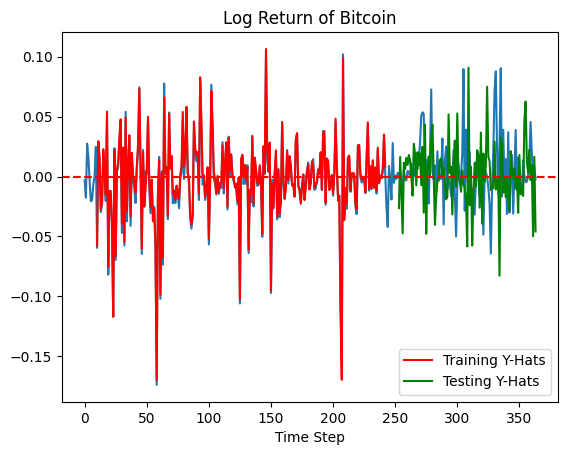

<Figure size 640x480 with 0 Axes>

In [22]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(diff) * np.nan
    y_hat_train = model(X_train)
    train_plot[lookback:train_size] = y_hat_train
    # shift test predictions for plotting
    test_plot = np.ones_like(diff) * np.nan
    y_hat_test = model(X_test)
    test_plot[train_size+lookback:len(diff)] = y_hat_test


# plot
plt.plot(diff)
plt.plot(train_plot, c='r', label="Training Y-Hats")
plt.plot(test_plot, c='g', label='Testing Y-Hats')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.axhline(y=0, color='r', linestyle='--')
plt.show()
plt.savefig("365 forecast")

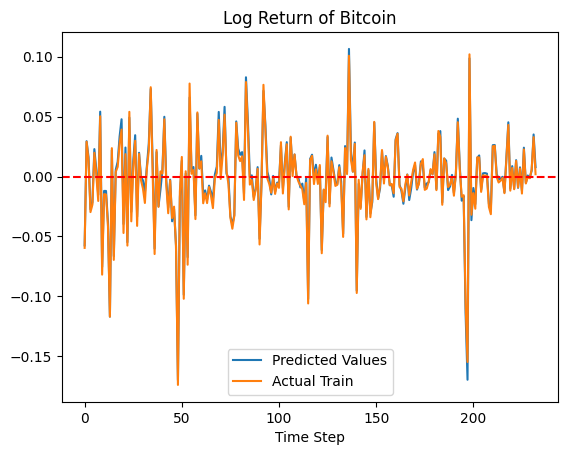

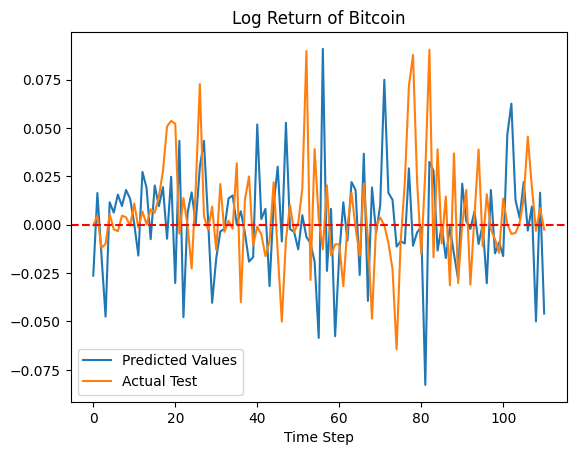

In [25]:
plt.plot(y_hat_train, label="Predicted Values")
plt.plot(y_train.squeeze(), label="Actual Train")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.show()
plt.savefig("Trained.png")

plt.plot(y_hat_test, label="Predicted Values")
plt.plot(y_test.squeeze(), label="Actual Test")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.savefig("Test.png")
plt.show()